In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
%matplotlib inline

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [40]:
df_t = load_iedb_tcellepitopes(human_only=True)

<AxesSubplot:>

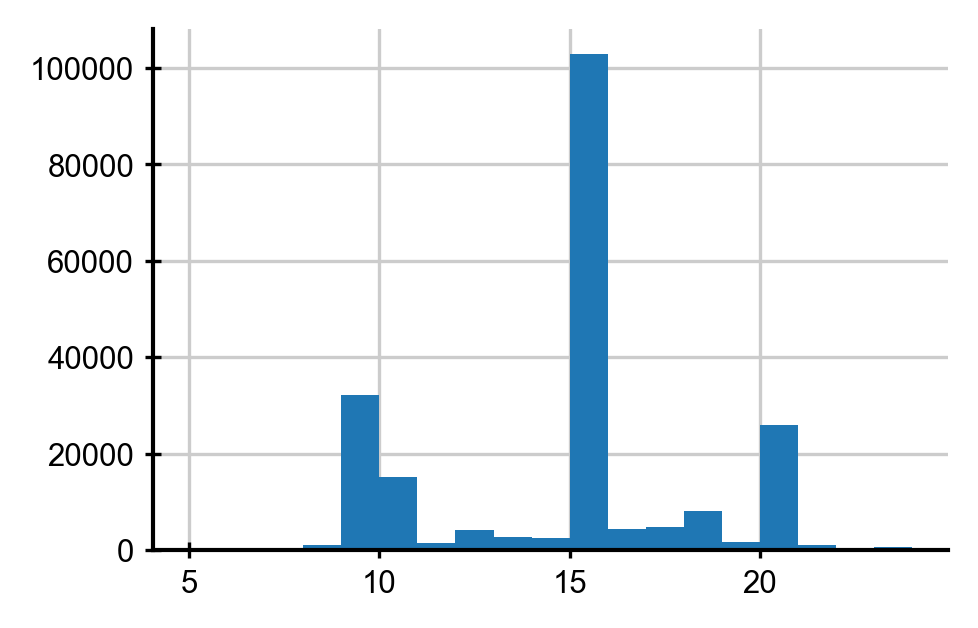

In [43]:
d = df_t[(df_t['Epitope', 'Length']>5) & (df_t['Epitope', 'Length']<25)]
d['Epitope', 'Length'].hist(bins=np.arange(5, 25, 1))

In [45]:
df_t = df_t[(df_t['Epitope', 'Length']<13)]

In [46]:
df_t[('Assay', 'Assay Group')].value_counts().head(10)

IFNg release                36368
proliferation                4968
cytotoxicity                 4958
qualitative binding          3917
IL-2 release                  571
TNFa release                  530
dissociation constant KD      509
IL-4 release                  344
CCL4/MIP-1b release           328
IL-10 release                 217
Name: (Assay, Assay Group), dtype: int64

In [47]:
d = df_t[df_t[('Assay', 'Assay Group')].isin(df_t[('Assay', 'Assay Group')].value_counts().head(10).index)]
d[[('Assay', 'Assay Group'), ('Assay', 'Positive')]].groupby(('Assay', 'Assay Group')).agg('mean').head(10)

,Assay
,Positive
"(Assay, Assay Group)",
CCL4/MIP-1b release,0.917683
IFNg release,0.263281
IL-10 release,0.691244
IL-2 release,0.812609
IL-4 release,0.787791
TNFa release,0.847170
cytotoxicity,0.810609
dissociation constant KD,0.886051


In [51]:
df_t['Assay', 'Method/Technique'].value_counts().head(10)

ELISPOT                            31763
3H-thymidine                        4475
51 chromium                         4185
multimer/tetramer                   3910
ICS                                 3875
ELISA                               3004
in vitro assay                       845
biological activity                  562
surface plasmon resonance (SPR)      481
binding assay                        440
Name: (Assay, Method/Technique), dtype: int64

In [54]:
d = df_t[df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(10).index)]
d[[('Assay', 'Method/Technique'), ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')

,Assay
,Positive
"(Assay, Method/Technique)",
3H-thymidine,0.592179
51 chromium,0.799044
ELISA,0.757324
ELISPOT,0.197746
ICS,0.732645
binding assay,0.995455
biological activity,0.839858
in vitro assay,0.857988


<AxesSubplot:xlabel='(Assay, Method/Technique)'>

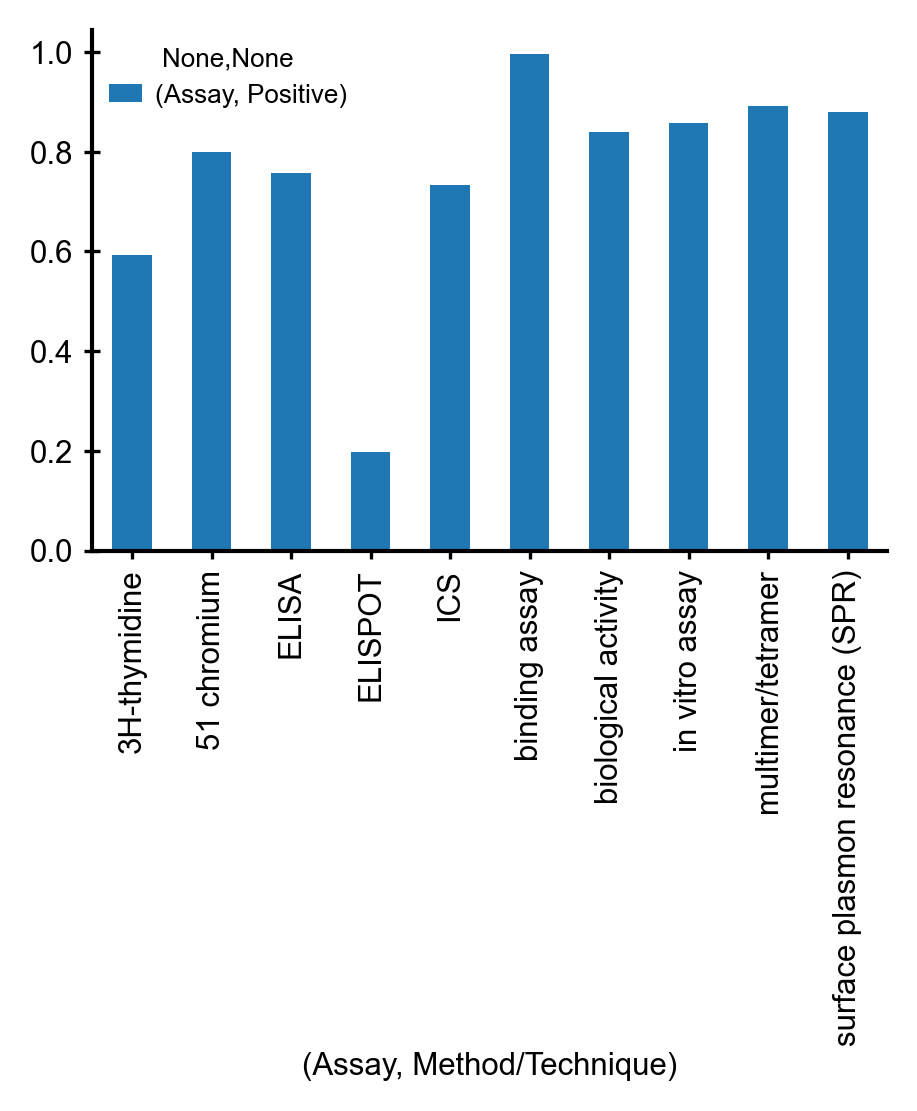

In [60]:
d[[('Assay', 'Method/Technique'), ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean').plot(kind='bar')

In [58]:
df_t[df_t['Assay', 'Method/Technique']=='ELISPOT']['Assay', 'Assay Group'].value_counts()

IFNg release          31527
IL-5 release             85
granzyme B release       79
TNF release              24
IL-10 release            23
IL-4 release             16
IL-2 release              4
IL-17A release            2
IL-13 release             2
IL-17 release             1
Name: (Assay, Assay Group), dtype: int64